
================  DAILY TRADING LOG  ================

2025-01-01  |  FLAT  |  NAV stays 10,000.00
2025-01-02 | FX SPOT | SHORT | 10,000.00$ | ret -1.09% -> pnl +109.45
2025-01-03 | APPLE | LONG  | 1,237.12$ | ret -0.20% -> pnl -2.49
2025-01-03 | BOEING | LONG  | 1,428.09$ | ret -1.15% -> pnl -16.37
2025-01-03 | CITI  | LONG  | 1,981.43$ | ret +1.52% -> pnl +30.03
2025-01-03 | BRENT | LONG  | 1,739.16$ | ret +0.76% -> pnl +13.28
2025-01-03 | MCDONALDS | LONG  | 1,895.51$ | ret +0.78% -> pnl +14.71
2025-01-03 | S&P 500 | LONG  | 1,828.14$ | ret +1.26% -> pnl +23.03
2025-01-06 | APPLE | LONG  | 1,382.39$ | ret +0.67% -> pnl +9.32
2025-01-06 | BOEING | LONG  | 1,688.62$ | ret +0.52% -> pnl +8.75
2025-01-06 | BRENT | LONG  | 2,071.62$ | ret -0.27% -> pnl -5.69
2025-01-06 | COCACOLA | LONG  | 1,216.51$ | ret -1.52% -> pnl -18.52
2025-01-06 | GOLD  | SHORT | 338.74$ | ret -0.27% -> pnl +0.93
2025-01-06 | S&P 500 | LONG  | 2,387.68$ | ret +0.55% -> pnl +13.22
2025-01-06 | US BONDS | SHORT | 

/tmp/ipykernel_924584/3121491425.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  basket_df[f"{a}_sig" ].fillna(0, inplace=True)   # no signal  → flat
/tmp/ipykernel_924584/3121491425.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

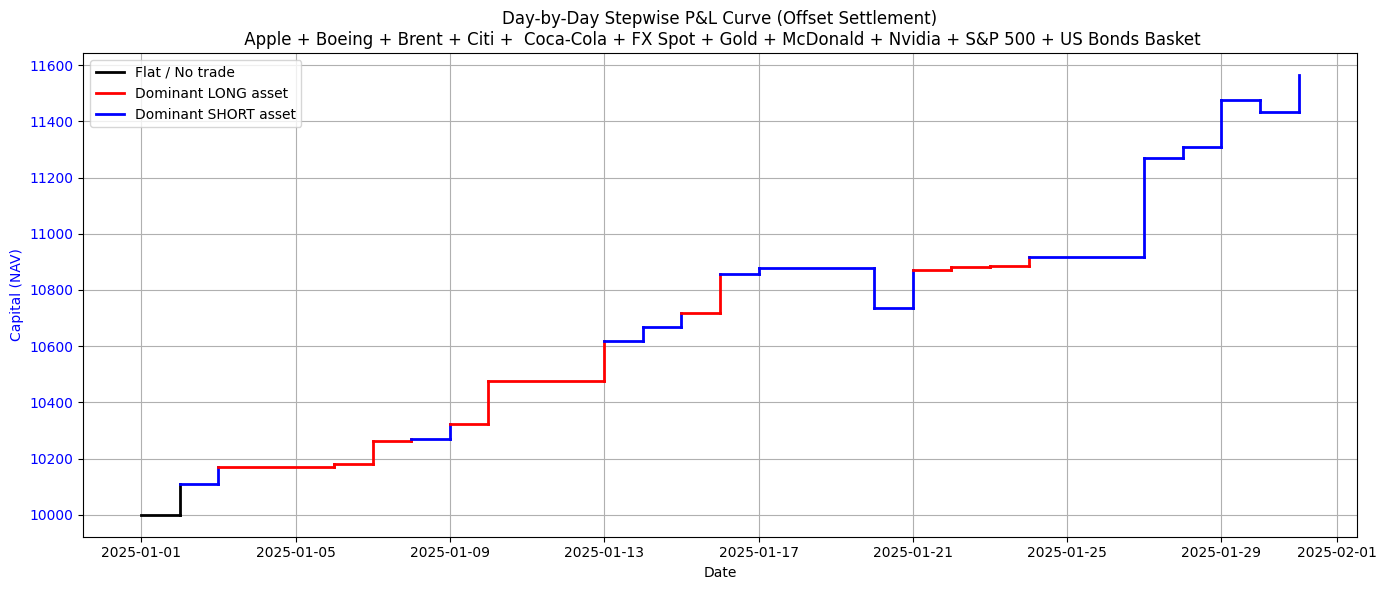

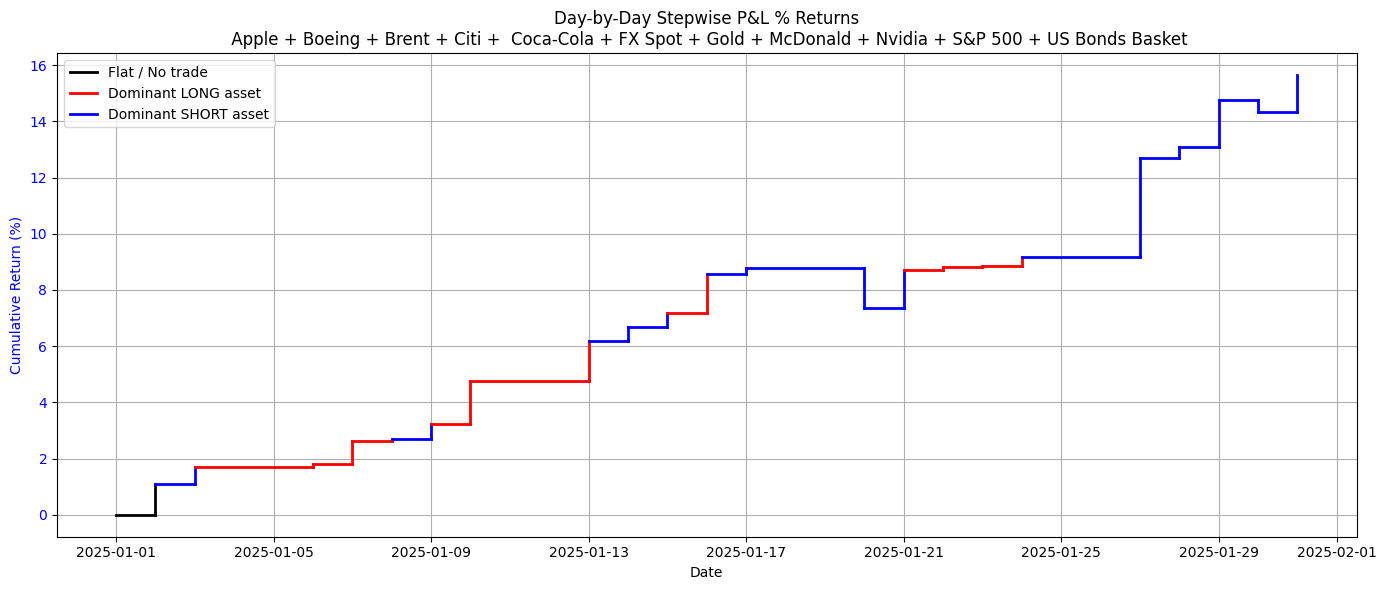

In [5]:
###############################################################################
# basket_trade_three_assets.py  –  Jan‑2025 basket trading (Citi + Brent + Coca‑Cola)
###############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# --------------------------------------------------------------------------- #
# 0) CONFIGURATION                                                            #
# --------------------------------------------------------------------------- #
INIT_NAV   = 10_000          # initial portfolio value
MAX_WEIGHT = 0.75            # per‑asset weight cap
ASSETS = {
    "Apple":      dict(sig="signals_apple.csv",      conf="confidence_apple.csv",      ret="returns_apple.csv"),
    "Boeing":  dict(sig="signals_boeing.csv",  conf="confidence_boeing.csv",  ret="returns_boeing.csv"),
    "Citi":      dict(sig="signals_citi.csv",      conf="confidence_citi.csv",      ret="returns_citi.csv"),
    "Brent":     dict(sig="signals_brentoil.csv",  conf="confidence_brentoil.csv",  ret="returns_brentoil.csv"),
    "Cocacola":  dict(sig="signals_cocacola.csv",  conf="confidence_cocacola.csv",  ret="returns_cocacola.csv"),
    "FX Spot":  dict(sig="signals_fx_spot.csv",  conf="confidence_fx_spot.csv",  ret="returns_fx_spot.csv"),
    "Gold":  dict(sig="signals_gold.csv",  conf="confidence_gold.csv",  ret="returns_gold.csv"),
    "Mcdonalds":  dict(sig="signals_mcdonald.csv",  conf="confidence_mcdonald.csv",  ret="returns_mcdonald.csv"),
    "Nvidia":  dict(sig="signals_nvidia.csv",  conf="confidence_nvidia.csv",  ret="returns_nvidia.csv"),
    "S&P 500":  dict(sig="signals_s&p_500.csv",  conf="confidence_s&p_500.csv",  ret="returns_s&p_500.csv"),
    "Silver":  dict(sig="signals_silver.csv",  conf="confidence_silver.csv",  ret="returns_silver.csv"),
    "US Bonds":  dict(sig="signals_us_bonds.csv",  conf="confidence_us_bonds.csv",  ret="returns_us_bonds.csv"),
}
OUT_BASKET_NAV = "basket_nav_jan25_12assets.csv"
DATE_SLICE      = slice("2025-01-01", "2025-01-31")    # convenience
# --------------------------------------------------------------------------- #

def _load_col(fname: str, colname: str) -> pd.Series:
    """Load one column from CSV indexed by *date*."""
    s = (pd.read_csv(fname, parse_dates=["date"])
           .set_index("date")[colname])
    if not s.index.is_monotonic_increasing:
        s = s.sort_index()
    return s

# -------- 1) load & merge the feeds ---------------------------------------- #
frames = []
for asset, f in ASSETS.items():
    sig  = _load_col(f["sig"],  "signal").rename(f"{asset}_sig")
    conf = _load_col(f["conf"], "conf"  ).rename(f"{asset}_conf")
    ret  = _load_col(f["ret"],  "ret"   ).rename(f"{asset}_ret")
    frames.append(pd.concat([sig, conf, ret], axis=1))

basket_df = pd.concat(frames, axis=1).loc[DATE_SLICE].sort_index()

# -------- 1b) sanitise missing data ---------------------------------------- #
for a in ASSETS:
    basket_df[f"{a}_sig" ].fillna(0, inplace=True)   # no signal  → flat
    basket_df[f"{a}_conf"].fillna(0, inplace=True)   # no confidence → ignore asset
    basket_df[f"{a}_ret" ].fillna(0, inplace=True)   # missing return → no PnL

# -------- 2) back‑test loop ------------------------------------------------ #
nav_hist, trade_log = [], []
nav = INIT_NAV

for dt, row in basket_df.iterrows():

    active = [a for a in ASSETS if row[f"{a}_sig"] != 0]
    if not active:                                  # all flat
        nav_hist.append({"date": dt, "nav": nav, "sig": 0})
        trade_log.append(f"{dt.date()}  |  FLAT  |  NAV stays {nav:,.2f}")
        continue

    # 2a) derive weights from confidences ------------------------------------
    confs    = {a: row[f"{a}_conf"] for a in active}
    tot_conf = sum(confs.values())
    if tot_conf <= 0 or np.isnan(tot_conf):
        weights = {a: 1/len(active) for a in active}
    else:
        weights = {a: min(confs[a]/tot_conf, MAX_WEIGHT) for a in active}
        scale   = 1 / sum(weights.values())
        weights = {a: w*scale for a, w in weights.items()}

    # 2b) apply PnL and pick *dominant* position -----------------------------
    daily_pnl   = 0.0
    dom_pnl_abs = -np.inf   # largest |pnl|
    dom_sig     = 0         # +1 (long) / ‑1 (short) / 0 (flat)
    for a in active:
        capital_i = nav * weights[a]
        pnl_i     = capital_i * row[f"{a}_sig"] * row[f"{a}_ret"]
        daily_pnl += pnl_i

        # track the trade with greatest absolute impact
        if abs(pnl_i) > dom_pnl_abs:
            dom_pnl_abs = abs(pnl_i)
            dom_sig     = int(np.sign(row[f"{a}_sig"]))

        trade_log.append(
            f"{dt.date()} | {a.upper():5s} | "
            f"{'LONG' if row[f'{a}_sig']>0 else 'SHORT':5s} | "
            f"{capital_i:,.2f}$ | ret {row[f'{a}_ret']*100:+.2f}% -> pnl {pnl_i:+.2f}"
        )

    nav += daily_pnl
    nav_hist.append({"date": dt, "nav": nav, "sig": dom_sig})

# -------- 3) results to CSV + console summary ------------------------------ #
nav_df = pd.DataFrame(nav_hist).set_index("date")
nav_df["cum_ret_%"] = 100 * (nav_df["nav"]/INIT_NAV - 1)
nav_df.to_csv(OUT_BASKET_NAV, float_format="%.6f")

print("\n================  DAILY TRADING LOG  ================\n")
for line in trade_log:
    print(line)

final_ret = nav_df["cum_ret_%"].iloc[-1]
print("\n================  SUMMARY  ==========================")
print(f"Final NAV: {nav_df['nav'].iloc[-1]:,.2f} ({final_ret:+.2f} %)  —  written → {OUT_BASKET_NAV}")

# --------------------------------------------------------------------------- #
# 4) PLOTTING  –  step‑wise curves coloured by dominant position              #
# --------------------------------------------------------------------------- #
def _step_plot(ax, x, y, sig):
    colour = {1: "red", -1: "blue", 0: "black"}
    for i in range(1, len(x)):
        c = colour.get(sig[i-1], "black")
        ax.plot([x[i-1], x[i]], [y[i-1], y[i-1]], color=c, lw=2)  # horizontal
        ax.plot([x[i], x[i]],   [y[i-1], y[i]],   color=c, lw=2)  # vertical

def _plot_core(series, ylabel, title):
    fig, ax = plt.subplots(figsize=(14,6))
    dates = series.index.to_pydatetime()
    _step_plot(ax, dates, series.values, nav_df["sig"].values)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel, color="blue")
    ax.tick_params(axis="y", labelcolor="blue")
    ax.grid(True)
    legend = [
        Line2D([0],[0], color='black', lw=2, label='Flat / No trade'),
        Line2D([0],[0], color='red',   lw=2, label='Dominant LONG asset'),
        Line2D([0],[0], color='blue',  lw=2, label='Dominant SHORT asset')
    ]
    ax.legend(handles=legend, loc="upper left")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

_plot_core(nav_df["nav"],
           "Capital (NAV)",
           "Day-by-Day Stepwise P&L Curve (Offset Settlement)\n Apple + Boeing + Brent + Citi +  Coca-Cola + FX Spot + Gold + McDonald + Nvidia + S&P 500 + US Bonds Basket")

_plot_core(nav_df["cum_ret_%"],
           "Cumulative Return (%)",
           "Day-by-Day Stepwise P&L % Returns\n Apple + Boeing + Brent + Citi +  Coca-Cola + FX Spot + Gold + McDonald + Nvidia + S&P 500 + US Bonds Basket")



================  DAILY TRADING LOG  ================

2025-01-01  |  FLAT  |  NAV stays 10,000.00
2025-01-02 | FX SPOT | SHORT | 10,000.00$ | ret -1.09% -> pnl +109.45
2025-01-03 | APPLE | LONG  | 1,237.12$ | ret -0.20% -> pnl -2.49
2025-01-03 | BOEING | LONG  | 1,428.09$ | ret -1.15% -> pnl -16.37
2025-01-03 | CITI  | LONG  | 1,981.43$ | ret +1.52% -> pnl +30.03
2025-01-03 | BRENT | LONG  | 1,739.16$ | ret +0.76% -> pnl +13.28
2025-01-03 | MCDONALDS | LONG  | 1,895.51$ | ret +0.78% -> pnl +14.71
2025-01-03 | S&P 500 | LONG  | 1,828.14$ | ret +1.26% -> pnl +23.03
2025-01-06 | APPLE | LONG  | 1,382.39$ | ret +0.67% -> pnl +9.32
2025-01-06 | BOEING | LONG  | 1,688.62$ | ret +0.52% -> pnl +8.75
2025-01-06 | BRENT | LONG  | 2,071.62$ | ret -0.27% -> pnl -5.69
2025-01-06 | COCACOLA | LONG  | 1,216.51$ | ret -1.52% -> pnl -18.52
2025-01-06 | GOLD  | SHORT | 338.74$ | ret -0.27% -> pnl +0.93
2025-01-06 | S&P 500 | LONG  | 2,387.68$ | ret +0.55% -> pnl +13.22
2025-01-06 | US BONDS | SHORT | 

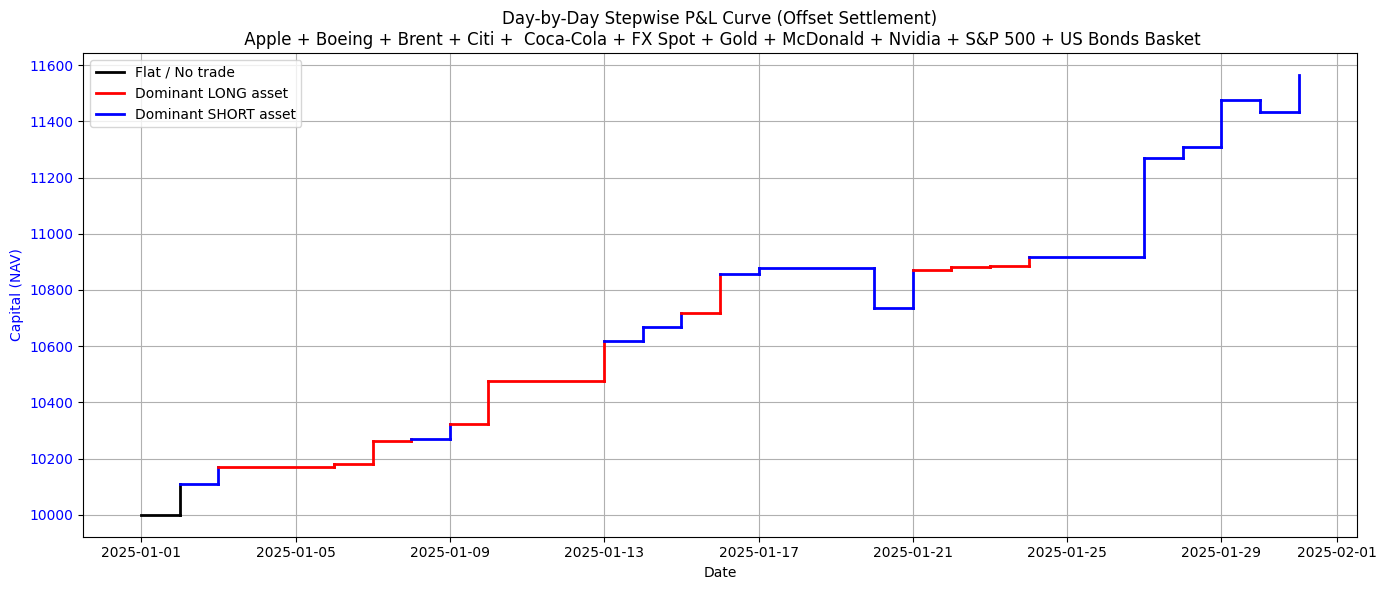

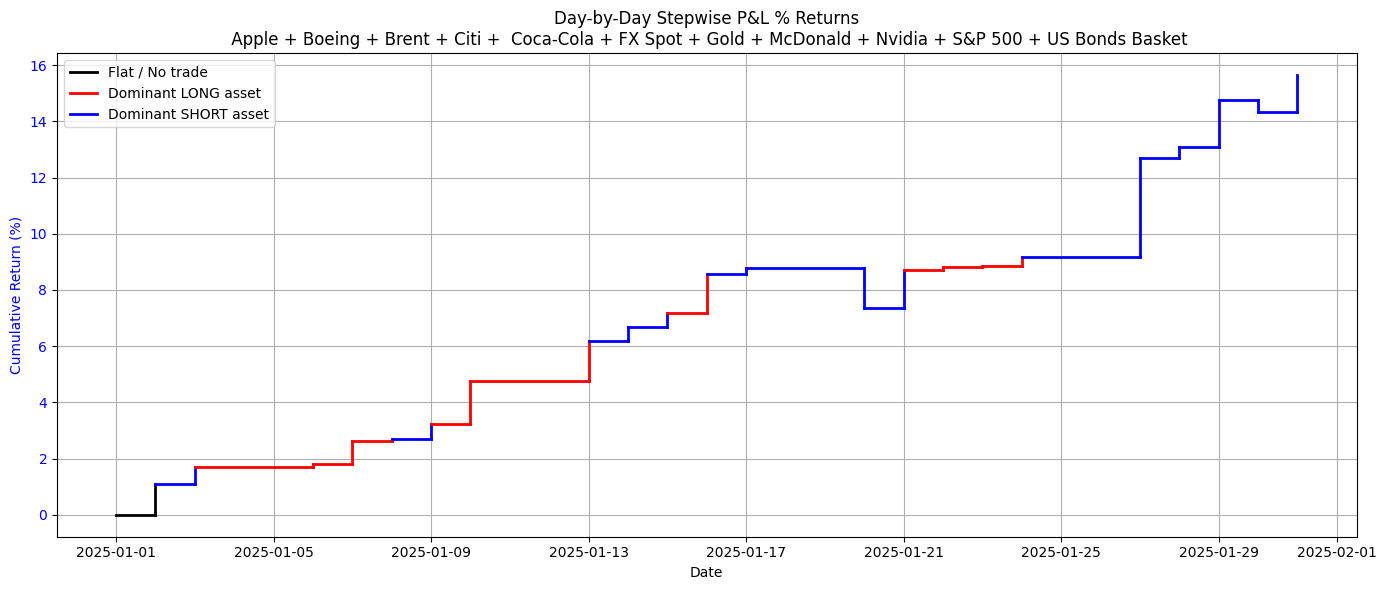

In [6]:
###############################################################################
# basket_trade_three_assets.py  –  Jan‑2025 basket trading (Citi + Brent + Coca‑Cola)
###############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# --------------------------------------------------------------------------- #
# 0) CONFIGURATION                                                            #
# --------------------------------------------------------------------------- #
INIT_NAV   = 10_000          # initial portfolio value
MAX_WEIGHT = 0.75            # per‑asset weight cap
ASSETS = {
    "Apple":      dict(sig="signals_apple.csv",      conf="confidence_apple.csv",      ret="returns_apple.csv"),
    "Boeing":  dict(sig="signals_boeing.csv",  conf="confidence_boeing.csv",  ret="returns_boeing.csv"),
    "Citi":      dict(sig="signals_citi.csv",      conf="confidence_citi.csv",      ret="returns_citi.csv"),
    "Brent":     dict(sig="signals_brentoil.csv",  conf="confidence_brentoil.csv",  ret="returns_brentoil.csv"),
    "Cocacola":  dict(sig="signals_cocacola.csv",  conf="confidence_cocacola.csv",  ret="returns_cocacola.csv"),
    "FX Spot":  dict(sig="signals_fx_spot.csv",  conf="confidence_fx_spot.csv",  ret="returns_fx_spot.csv"),
    "Gold":  dict(sig="signals_gold.csv",  conf="confidence_gold.csv",  ret="returns_gold.csv"),
    "Mcdonalds":  dict(sig="signals_mcdonald.csv",  conf="confidence_mcdonald.csv",  ret="returns_mcdonald.csv"),
    "Nvidia":  dict(sig="signals_nvidia.csv",  conf="confidence_nvidia.csv",  ret="returns_nvidia.csv"),
    "S&P 500":  dict(sig="signals_s&p_500.csv",  conf="confidence_s&p_500.csv",  ret="returns_s&p_500.csv"),
    "Silver":  dict(sig="signals_silver.csv",  conf="confidence_silver.csv",  ret="returns_silver.csv"),
    "US Bonds":  dict(sig="signals_us_bonds.csv",  conf="confidence_us_bonds.csv",  ret="returns_us_bonds.csv"),
}
OUT_BASKET_NAV = "basket_nav_jan25_12assets.csv"
DATE_SLICE      = slice("2025-01-01", "2025-01-31")    # convenience
# --------------------------------------------------------------------------- #

def _load_col(fname: str, colname: str) -> pd.Series:
    """Load one column from CSV indexed by *date*."""
    s = (pd.read_csv(fname, parse_dates=["date"])
           .set_index("date")[colname])
    if not s.index.is_monotonic_increasing:
        s = s.sort_index()
    return s

# -------- 1) load & merge the feeds ---------------------------------------- #
frames = []
for asset, f in ASSETS.items():
    sig  = _load_col(f["sig"],  "signal").rename(f"{asset}_sig")
    conf = _load_col(f["conf"], "conf"  ).rename(f"{asset}_conf")
    ret  = _load_col(f["ret"],  "ret"   ).rename(f"{asset}_ret")
    frames.append(pd.concat([sig, conf, ret], axis=1))

basket_df = pd.concat(frames, axis=1).loc[DATE_SLICE].sort_index()

# -------- 1b) sanitise missing data ---------------------------------------- #
for a in ASSETS:
    basket_df[f"{a}_sig"] = basket_df[f"{a}_sig"].fillna(0)
    basket_df[f"{a}_conf"] = basket_df[f"{a}_conf"].fillna(0)
    basket_df[f"{a}_ret"]  = basket_df[f"{a}_ret"].fillna(0)

# -------- 2) back‑test loop ------------------------------------------------ #
nav_hist, trade_log = [], []
nav = INIT_NAV

for dt, row in basket_df.iterrows():

    active = [a for a in ASSETS if row[f"{a}_sig"] != 0]
    if not active:                                  # all flat
        nav_hist.append({"date": dt, "nav": nav, "sig": 0})
        trade_log.append(f"{dt.date()}  |  FLAT  |  NAV stays {nav:,.2f}")
        continue

    # 2a) derive weights from confidences ------------------------------------
    confs    = {a: row[f"{a}_conf"] for a in active}
    tot_conf = sum(confs.values())
    if tot_conf <= 0 or np.isnan(tot_conf):
        weights = {a: 1/len(active) for a in active}
    else:
        weights = {a: min(confs[a]/tot_conf, MAX_WEIGHT) for a in active}
        scale   = 1 / sum(weights.values())
        weights = {a: w*scale for a, w in weights.items()}

    # 2b) apply PnL and pick *dominant* position -----------------------------
    daily_pnl   = 0.0
    dom_pnl_abs = -np.inf   # largest |pnl|
    dom_sig     = 0         # +1 (long) / ‑1 (short) / 0 (flat)
    for a in active:
        capital_i = nav * weights[a]
        pnl_i     = capital_i * row[f"{a}_sig"] * row[f"{a}_ret"]
        daily_pnl += pnl_i

        # track the trade with greatest absolute impact
        if abs(pnl_i) > dom_pnl_abs:
            dom_pnl_abs = abs(pnl_i)
            dom_sig     = int(np.sign(row[f"{a}_sig"]))

        trade_log.append(
            f"{dt.date()} | {a.upper():5s} | "
            f"{'LONG' if row[f'{a}_sig']>0 else 'SHORT':5s} | "
            f"{capital_i:,.2f}$ | ret {row[f'{a}_ret']*100:+.2f}% -> pnl {pnl_i:+.2f}"
        )

    nav += daily_pnl
    nav_hist.append({"date": dt, "nav": nav, "sig": dom_sig})

# -------- 3) results to CSV + console summary ------------------------------ #
nav_df = pd.DataFrame(nav_hist).set_index("date")
nav_df["cum_ret_%"] = 100 * (nav_df["nav"]/INIT_NAV - 1)
nav_df.to_csv(OUT_BASKET_NAV, float_format="%.6f")

print("\n================  DAILY TRADING LOG  ================\n")
for line in trade_log:
    print(line)

final_ret = nav_df["cum_ret_%"].iloc[-1]
print("\n================  SUMMARY  ==========================")
print(f"Final NAV: {nav_df['nav'].iloc[-1]:,.2f} ({final_ret:+.2f} %)  —  written → {OUT_BASKET_NAV}")

# --------------------------------------------------------------------------- #
# 4) PLOTTING  –  step‑wise curves coloured by dominant position              #
# --------------------------------------------------------------------------- #
def _step_plot(ax, x, y, sig):
    colour = {1: "red", -1: "blue", 0: "black"}
    for i in range(1, len(x)):
        c = colour.get(sig[i-1], "black")
        ax.plot([x[i-1], x[i]], [y[i-1], y[i-1]], color=c, lw=2)  # horizontal
        ax.plot([x[i], x[i]],   [y[i-1], y[i]],   color=c, lw=2)  # vertical

def _plot_core(series, ylabel, title):
    fig, ax = plt.subplots(figsize=(14,6))
    dates = series.index.to_pydatetime()
    _step_plot(ax, dates, series.values, nav_df["sig"].values)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel, color="blue")
    ax.tick_params(axis="y", labelcolor="blue")
    ax.grid(True)
    legend = [
        Line2D([0],[0], color='black', lw=2, label='Flat / No trade'),
        Line2D([0],[0], color='red',   lw=2, label='Dominant LONG asset'),
        Line2D([0],[0], color='blue',  lw=2, label='Dominant SHORT asset')
    ]
    ax.legend(handles=legend, loc="upper left")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

_plot_core(nav_df["nav"],
           "Capital (NAV)",
           "Day-by-Day Stepwise P&L Curve (Offset Settlement)\n Apple + Boeing + Brent + Citi +  Coca-Cola + FX Spot + Gold + McDonald + Nvidia + S&P 500 + US Bonds Basket")

_plot_core(nav_df["cum_ret_%"],
           "Cumulative Return (%)",
           "Day-by-Day Stepwise P&L % Returns\n Apple + Boeing + Brent + Citi +  Coca-Cola + FX Spot + Gold + McDonald + Nvidia + S&P 500 + US Bonds Basket")
